In [1]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd

from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Generating train dataset and splitting it in train and test

In [15]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp_corrected_2", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})


from sklearn.model_selection import train_test_split

train, eval_df = train_test_split(train, test_size=0.1, stratify=train.labels)


In [17]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()


def get_stats(N: int, train=train, eval_df=eval_df, clf=clf):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())

    LABELS = ["hr", "bs", "sr", "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    bool_coverage = eval_df.coverage.value_counts()[0]
    per_lang_bool_coverage = {lang: bool_cov for lang, boolcov in (
        eval_df.labels.unique(),
        eval_df.loc[eval_df.labels==l].coverage.value_counts()[0]
    )}
    return {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage, "clf": clf.__str__(), "bool_coverage": bool_coverage,
    "bool_coverage_ratio": bool_coverage/len(y_true)}


In [18]:
Ns = np.logspace(1, 4, 30, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break

2022-01-14 11:34:43,665 - N=10
2022-01-14 11:34:45,412 - NumExpr defaulting to 8 threads.
2022-01-14 11:35:32,742 - N=12
2022-01-14 11:36:20,983 - N=16
2022-01-14 11:37:09,602 - N=20
2022-01-14 11:37:58,139 - N=25
2022-01-14 11:38:47,620 - N=32
2022-01-14 11:39:37,617 - N=41
2022-01-14 11:40:27,928 - N=52
2022-01-14 11:41:18,783 - N=67
2022-01-14 11:42:10,218 - N=85
2022-01-14 11:43:02,555 - N=108
2022-01-14 11:43:56,845 - N=137
2022-01-14 11:44:52,761 - N=174
2022-01-14 11:45:50,722 - N=221
2022-01-14 11:46:50,542 - N=280
2022-01-14 11:47:52,737 - N=356
2022-01-14 11:48:57,835 - N=452
2022-01-14 11:50:05,911 - N=573
2022-01-14 11:51:20,048 - N=727
2022-01-14 11:52:39,668 - N=923
2022-01-14 11:54:04,998 - N=1172
2022-01-14 11:55:38,944 - N=1487
2022-01-14 11:57:21,517 - N=1887
2022-01-14 11:59:16,113 - N=2395
2022-01-14 12:01:23,819 - N=3039
2022-01-14 12:03:45,216 - N=3856
2022-01-14 12:06:27,692 - N=4893
2022-01-14 12:09:33,686 - N=6210
2022-01-14 12:13:11,618 - N=7880
2022-01-14 12:

In [19]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("20_results_NB_on_10_percent_of_web_data_extended.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,bool_coverage_ratio,eval_df
N,,,,,,,,,
10,0.361408,0.313230,0.361408,"[[6147, 34, 38, 24], [6503, 341, 540, 180], [3...",0.577548,GaussianNB(),21564,0.650047,web crawl 10%
12,0.381093,0.337474,0.381093,"[[6135, 31, 53, 24], [6305, 378, 695, 186], [2...",0.703253,GaussianNB(),20032,0.603865,web crawl 10%
16,0.414735,0.370696,0.414735,"[[6125, 33, 60, 25], [5909, 448, 934, 273], [2...",0.990926,GaussianNB(),16971,0.511591,web crawl 10%
20,0.448377,0.405590,0.448377,"[[6108, 38, 71, 26], [5638, 577, 1038, 311], [...",1.256926,GaussianNB(),14879,0.448527,web crawl 10%
25,0.469991,0.425981,0.469991,"[[6113, 33, 73, 24], [5497, 621, 1063, 383], [...",1.522473,GaussianNB(),13430,0.404847,web crawl 10%
32,0.491846,0.446378,0.491846,"[[6097, 38, 78, 30], [5270, 682, 1136, 476], [...",1.820517,GaussianNB(),11917,0.359238,web crawl 10%
41,0.510867,0.467104,0.510867,"[[6086, 42, 89, 26], [5021, 807, 1267, 469], [...",2.247038,GaussianNB(),10140,0.305670,web crawl 10%
52,0.523709,0.476327,0.523709,"[[6094, 40, 85, 24], [4904, 795, 1237, 628], [...",2.637145,GaussianNB(),8922,0.268954,web crawl 10%
67,0.543906,0.498558,0.543906,"[[6089, 48, 91, 15], [4697, 959, 1200, 708], [...",3.150213,GaussianNB(),7574,0.228318,web crawl 10%


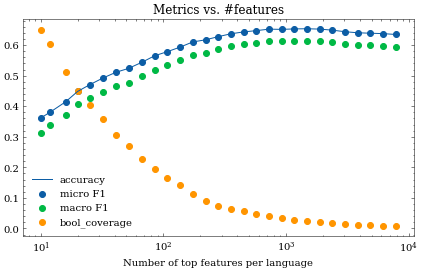

In [22]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.scatter(rezdf.index, rezdf["bool_coverage_ratio"],label="bool_coverage")
plt.legend()
plt.xlabel("Number of top features per language")


plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/20_in_domain_coverage_NB.png")
plt.show()

In [23]:
from sklearn.svm import LinearSVC
clf_lin_svc = LinearSVC(dual=False)
Ns = np.logspace(1, 4, 30, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf_lin_svc)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break


2022-01-14 12:22:00,798 - N=10
2022-01-14 12:22:52,445 - N=12
2022-01-14 12:23:44,755 - N=16
2022-01-14 12:24:37,710 - N=20
2022-01-14 12:25:31,380 - N=25
2022-01-14 12:26:27,353 - N=32
2022-01-14 12:27:23,768 - N=41
2022-01-14 12:28:19,980 - N=52
2022-01-14 12:29:17,979 - N=67
2022-01-14 12:30:18,061 - N=85
2022-01-14 12:31:20,076 - N=108
2022-01-14 12:32:24,962 - N=137
2022-01-14 12:33:31,404 - N=174
2022-01-14 12:34:38,804 - N=221
2022-01-14 12:35:51,341 - N=280
2022-01-14 12:37:10,625 - N=356
2022-01-14 12:38:32,193 - N=452
2022-01-14 12:39:52,386 - N=573
2022-01-14 12:41:22,270 - N=727
2022-01-14 12:42:57,310 - N=923
2022-01-14 12:44:35,557 - N=1172
2022-01-14 12:46:19,015 - N=1487
2022-01-14 12:48:09,901 - N=1887
2022-01-14 12:50:09,652 - N=2395


In [33]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("20_results_LinSVC_on_10_percent_of_web_data_extended.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,eval_df
N,,,,,,,,
10,0.471192,0.347547,0.471192,"[[1151, 188, 17, 4887], [354, 567, 64, 6579], ...",0.655300,LinearSVC(dual=False),19742,web crawl 10%
12,0.498064,0.397366,0.498064,"[[1450, 169, 50, 4574], [458, 596, 158, 6352],...",0.789890,LinearSVC(dual=False),18280,web crawl 10%
16,0.541519,0.531371,0.541519,"[[1879, 4114, 57, 193], [558, 5541, 177, 1288]...",1.097490,LinearSVC(dual=False),15490,web crawl 10%
20,0.566811,0.557717,0.566811,"[[1989, 3984, 56, 214], [588, 5345, 208, 1423]...",1.378476,LinearSVC(dual=False),13608,web crawl 10%
25,0.581392,0.572512,0.581392,"[[2147, 3737, 55, 304], [628, 5111, 218, 1607]...",1.660333,LinearSVC(dual=False),12274,web crawl 10%
32,0.597071,0.590480,0.597071,"[[2353, 3524, 56, 310], [669, 5128, 226, 1541]...",1.974934,LinearSVC(dual=False),10971,web crawl 10%
41,0.614265,0.609543,0.614265,"[[2531, 3382, 65, 265], [755, 5012, 261, 1536]...",2.431899,LinearSVC(dual=False),9403,web crawl 10%
52,0.626460,0.621909,0.626460,"[[2643, 3314, 66, 220], [789, 4989, 256, 1530]...",2.846603,LinearSVC(dual=False),8293,web crawl 10%
67,0.639880,0.633087,0.639880,"[[2793, 3127, 58, 265], [832, 4808, 245, 1679]...",3.393671,LinearSVC(dual=False),7057,web crawl 10%


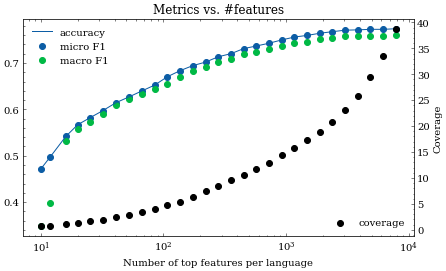

In [34]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.xlabel("Number of top features per language")

ax = plt.gca()
ax2 = plt.twinx()

ax2.scatter(rezdf.index, rezdf["coverage"], label="coverage", c="k")
ax2.set_ylabel("Coverage")
ax2.legend(loc="lower right")

plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/20_in_domain_coverage_LinSVC.png")
plt.show()